## IMPORTS

In [19]:
import sqlite3
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import tree, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


from sklearn import naive_bayes
import xgboost as xgb



In [2]:
con = sqlite3.connect('fires.sqlite')

## Pulling information from the sqlite file and converting it to a pandas df for easier manipulation

In [139]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,CONT_DATE,CONT_TIME,FIRE_SIZE_CLASS, OWNER_CODE, SOURCE_SYSTEM_TYPE,DISCOVERY_DOY,CONT_DOY FROM 'Fires'", con)
df.head() #check the data

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,CONT_DATE,CONT_TIME,FIRE_SIZE_CLASS,OWNER_CODE,SOURCE_SYSTEM_TYPE,DISCOVERY_DOY,CONT_DOY
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,1300,0.10,2453403.5,1730,A,5.0,FED,33,33.0
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0845,0.25,2453137.5,1530,A,5.0,FED,133,133.0
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,1921,0.10,2453156.5,2024,A,13.0,FED,152,152.0
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,1600,0.10,2453189.5,1400,A,5.0,FED,180,185.0
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,1600,0.10,2453189.5,1200,A,5.0,FED,180,185.0


In [140]:
#changing julian date to normal date so I can take out months + day of week later
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['CONTDATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df.head() 

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,CONT_DATE,CONT_TIME,FIRE_SIZE_CLASS,OWNER_CODE,SOURCE_SYSTEM_TYPE,DISCOVERY_DOY,CONT_DOY,DATE,CONTDATE
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,1300,0.10,2453403.5,1730,A,5.0,FED,33,33.0,2005-02-02,2005-02-02
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0845,0.25,2453137.5,1530,A,5.0,FED,133,133.0,2004-05-12,2004-05-12
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,1921,0.10,2453156.5,2024,A,13.0,FED,152,152.0,2004-05-31,2004-05-31
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,1600,0.10,2453189.5,1400,A,5.0,FED,180,185.0,2004-06-28,2004-07-03
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,1600,0.10,2453189.5,1200,A,5.0,FED,180,185.0,2004-06-28,2004-07-03


In [472]:
df['STAT_CAUSE_DESCR'].value_counts()

Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: STAT_CAUSE_DESCR, dtype: int64

In [142]:
# Create discovery datetime objects - including time
df['disc_datetime'] = df.apply(lambda row: datetime.strptime(
            str(row.FIRE_YEAR) + 
            str(row.DISCOVERY_DOY) + 
            str(row.DISCOVERY_TIME), '%Y%j%H%M') if row.DISCOVERY_TIME else np.nan, axis=1)

# Create contained datetime objects - including time
df['cont_datetime'] = df.apply(lambda row: datetime.strptime(
            str(row.FIRE_YEAR) + 
            str(int(row.'CONT_DOY)) + 
            str(row.CONT_TIME), '%Y%j%H%M') if row.CONT_TIME else np.nan, axis=1)

# Create Duration
df['duration'] = df['cont_datetime'] - df['disc_datetime']

# Correct duration
df['duration'] = df['duration'].apply(
    lambda x: x + timedelta(days=365) if x and x < timedelta(days=0) else x)

In [160]:
len(df)

1880465

In [143]:
df['DISC_MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DISC_DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
df['CONT_MONTH'] = pd.DatetimeIndex(df['CONTDATE']).month
df['CONT_DAY_OF_WEEK'] = df['CONTDATE'].dt.weekday_name

df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,CONT_DATE,CONT_TIME,...,CONT_DOY,DATE,CONTDATE,disc_datetime,cont_datetime,duration,DISC_MONTH,DISC_DAY_OF_WEEK,CONT_MONTH,CONT_DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,1300,0.10,2453403.5,1730,...,33.0,2005-02-02,2005-02-02,2005-11-27 03:00:00,2005-11-27 07:30:00,0 days 04:30:00,2,Wednesday,2.0,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0845,0.25,2453137.5,1530,...,133.0,2004-05-12,2004-05-12,2004-05-12 08:45:00,2004-05-12 15:30:00,0 days 06:45:00,5,Wednesday,5.0,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,1921,0.10,2453156.5,2024,...,152.0,2004-05-31,2004-05-31,2004-05-31 19:21:00,2004-05-31 20:24:00,0 days 01:03:00,5,Monday,5.0,Monday
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,1600,0.10,2453189.5,1400,...,185.0,2004-06-28,2004-07-03,2004-06-28 16:00:00,2004-07-03 14:00:00,4 days 22:00:00,6,Monday,7.0,Saturday
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,1600,0.10,2453189.5,1200,...,185.0,2004-06-28,2004-07-03,2004-06-28 16:00:00,2004-07-03 12:00:00,4 days 20:00:00,6,Monday,7.0,Saturday


In [180]:
df['duration'] = df['duration']/timedelta(days=1)

In [ ]:
df = df.drop('DISCOVERY_DATE', axis = 1)
df = df.drop('DISCOVERY_TIME', axis = 1)
df = df.drop('CONT_DATE', axis = 1)
df = df.drop('CONT_TIME', axis = 1)
df = df.drop('DISCOVERY_DOY', axis = 1)
df = df.drop('CONT_DOY', axis = 1)
df = df.drop('disc_datetime', axis = 1)
df = df.drop('cont_datetime', axis = 1)

In [205]:
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_CODE,SOURCE_SYSTEM_TYPE,DATE,CONTDATE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,CONT_MONTH,CONT_DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,0.10,A,5.0,FED,2005-02-02,2005-02-02,0.187500,2,Wednesday,2.0,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,0.25,A,5.0,FED,2004-05-12,2004-05-12,0.281250,5,Wednesday,5.0,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,0.10,A,13.0,FED,2004-05-31,2004-05-31,0.043750,5,Monday,5.0,Monday
3,2004,Lightning,38.559167,-119.913333,CA,0.10,A,5.0,FED,2004-06-28,2004-07-03,4.916667,6,Monday,7.0,Saturday
4,2004,Lightning,38.559167,-119.933056,CA,0.10,A,5.0,FED,2004-06-28,2004-07-03,4.833333,6,Monday,7.0,Saturday


In [519]:
df.corr()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,CONT_MONTH
FIRE_YEAR,1.000000,0.000407,0.015863,0.007048,-0.025825,0.032852,-0.007999,-0.004511
LATITUDE,0.000407,1.000000,-0.354727,0.038860,-0.304302,-0.006095,0.147484,0.166433
LONGITUDE,0.015863,-0.354727,1.000000,-0.039731,0.395288,0.001646,-0.243395,-0.279099
FIRE_SIZE,0.007048,0.038860,-0.039731,1.000000,-0.029635,0.063181,0.005695,0.023041
OWNER_CODE,-0.025825,-0.304302,0.395288,-0.029635,1.000000,0.007869,-0.136725,-0.159824
duration,0.032852,-0.006095,0.001646,0.063181,0.007869,1.000000,-0.099488,-0.069417
DISC_MONTH,-0.007999,0.147484,-0.243395,0.005695,-0.136725,-0.099488,1.000000,0.993859
CONT_MONTH,-0.004511,0.166433,-0.279099,0.023041,-0.159824,-0.069417,0.993859,1.000000


In [204]:
df.to_csv('fire_data.csv')

In [20]:
df = pd.read_csv('fire_data.csv')

/Users/djurk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [225]:
df.isnull().sum()

FIRE_YEAR                  0
STAT_CAUSE_DESCR           0
LATITUDE                   0
LONGITUDE                  0
STATE                      0
FIRE_SIZE                  0
FIRE_SIZE_CLASS            0
OWNER_CODE                 0
SOURCE_SYSTEM_TYPE         0
DATE                       0
CONTDATE              891531
duration              988458
DISC_MONTH                 0
DISC_DAY_OF_WEEK           0
CONT_MONTH            891531
CONT_DAY_OF_WEEK      891531
dtype: int64

In [21]:
dig_deeper = df.groupby(['STAT_CAUSE_DESCR','FIRE_YEAR','DISC_MONTH']).count().groupby(['STAT_CAUSE_DESCR','DISC_MONTH']).mean()

In [22]:
dig_deeper.head()

Unnamed: 0     LATITUDE    LONGITUDE  \
STAT_CAUSE_DESCR DISC_MONTH                                          
Arson            1            683.791667   683.791667   683.791667   
                 2           1173.833333  1173.833333  1173.833333   
                 3           2024.166667  2024.166667  2024.166667   
                 4           1956.833333  1956.833333  1956.833333   
                 5            994.875000   994.875000   994.875000   

                                   STATE    FIRE_SIZE  FIRE_SIZE_CLASS  \
STAT_CAUSE_DESCR DISC_MONTH                                              
Arson            1            683.791667   683.791667       683.791667   
                 2           1173.833333  1173.833333      1173.833333   
                 3           2024.166667  2024.166667      2024.166667   
                 4           1956.833333  1956.833333      1956.833333   
                 5            994.875000   994.875000       994.875000   

                              OWNER_CODE  SOURCE_SYSTEM_TYPE         DATE  \
STAT_CAUSE_DESCR DISC_MONTH                                                 
Arson            1            683.791667          683.791667   683.791667   
                 2           1173.833333         1173.833333  1173.833333   
                 3           2024.166667         2024.166667  2024.166667   
                 4           1956.833333         1956.833333  1956.833333   
                 5            994.875000          994.875000   994.875000   

                                CONTDATE    duration  DISC_DAY_OF_WEEK  \
STAT_CAUSE_DESCR DISC_MONTH                                              
Arson            1            358.666667  343.875000        683.791667   
                 2            599.333333  574.291667       1173.833333   
                 3           1035.041667  980.208333       2024.166667   
                 4           1021.750000  970.583333       1956.833333   
                 5            547.416667  525.083333        994.875000   

                              CONT_MONTH  CONT_DAY_OF_WEEK  
STAT_CAUSE_DESCR DISC_MONTH                                 
Arson            1            358.666667        358.666667  
                 2            599.333333        599.333333  
                 3           1035.041667       1035.041667  
                 4           1021.750000       1021.750000  
                 5            547.416667        547.416667

## Plotting monthly counts of fires to see trends

In [23]:
avg = dig_deeper['LONGITUDE'].reset_index()
avg.rename(columns={'LONGITUDE': 'AVERAGE_FIRES'}, inplace=True)

In [24]:
avg.head()

,STAT_CAUSE_DESCR,DISC_MONTH,AVERAGE_FIRES
0,Arson,1,683.791667
1,Arson,2,1173.833333
2,Arson,3,2024.166667
3,Arson,4,1956.833333
4,Arson,5,994.875000


In [25]:
names = avg['STAT_CAUSE_DESCR'].unique()
names

array(['Arson', 'Campfire', 'Children', 'Debris Burning', 'Equipment Use',
       'Fireworks', 'Lightning', 'Miscellaneous', 'Missing/Undefined',
       'Powerline', 'Railroad', 'Smoking', 'Structure'], dtype=object)

In [26]:
#data for each category
arson = avg['AVERAGE_FIRES'][0:12]
campfire = avg['AVERAGE_FIRES'][12:24]
children = avg['AVERAGE_FIRES'][24:36]
debris = avg['AVERAGE_FIRES'][36:48]
equipment = avg['AVERAGE_FIRES'][48:60]
fireworks = avg['AVERAGE_FIRES'][60:72]
lightning = avg['AVERAGE_FIRES'][72:84]
misc = avg['AVERAGE_FIRES'][84:96]
miss = avg['AVERAGE_FIRES'][96:108]
powerline = avg['AVERAGE_FIRES'][108:120]
railroad = avg['AVERAGE_FIRES'][120:132]
smoking = avg['AVERAGE_FIRES'][132:144]
structure = avg['AVERAGE_FIRES'][144:156]
cat_list = (arson,campfire,children,debris,equipment,fireworks,
            lightning,misc,miss,powerline,railroad,smoking,structure)



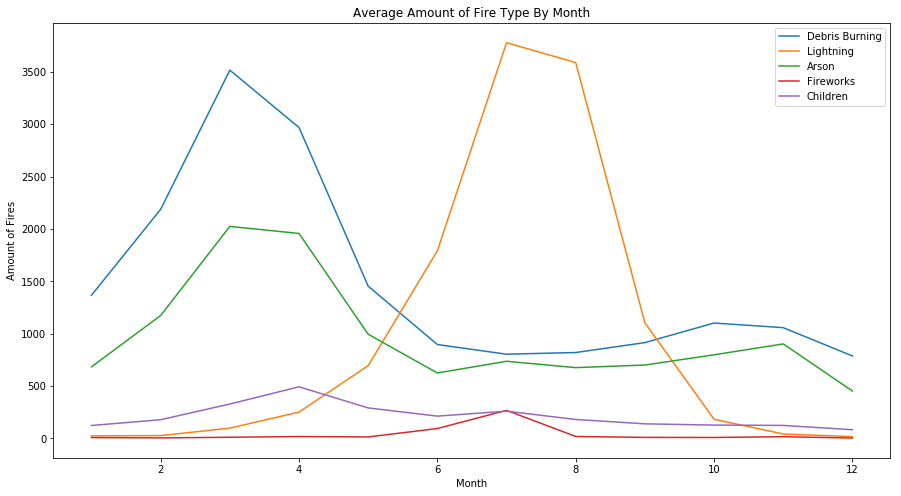

In [34]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,13),debris)
plt.plot(np.arange(1,13),lightning)
plt.plot(np.arange(1,13),arson)
plt.plot(np.arange(1,13),fireworks)
plt.plot(np.arange(1,13),children)

plt.xlabel('Month')
plt.ylabel('Amount of Fires')
plt.title('Average Amount of Fire Type By Month')
plt.legend(['Debris Burning','Lightning','Arson','Fireworks','Children'])

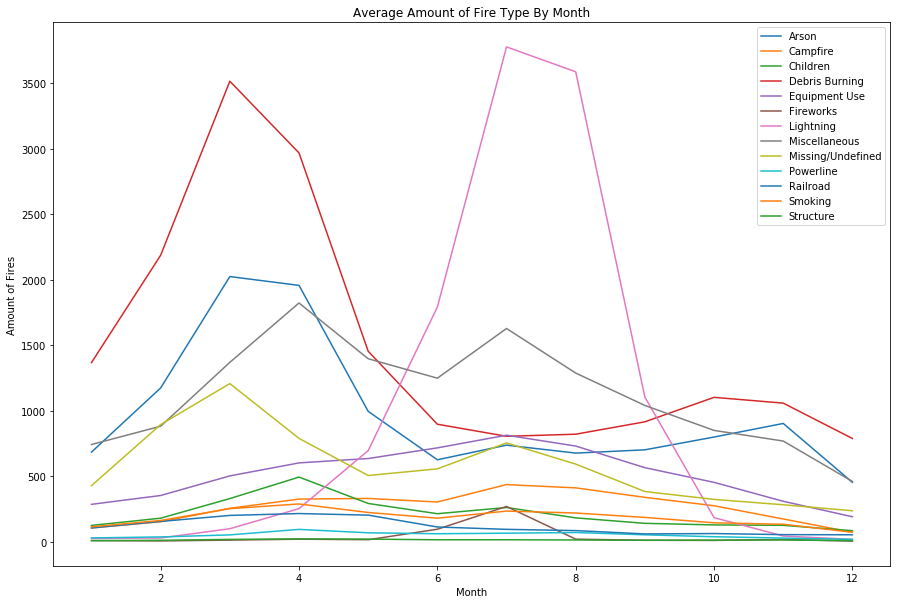

In [27]:
#plot shows clear seasonal trends in multiple categories of fires

plt.figure(figsize=(15,10))
for item in cat_list:
    plt.plot(np.arange(1,13),item)
plt.xlabel('Month')
plt.ylabel('Amount of Fires')
plt.title('Average Amount of Fire Type By Month')
plt.legend(names);


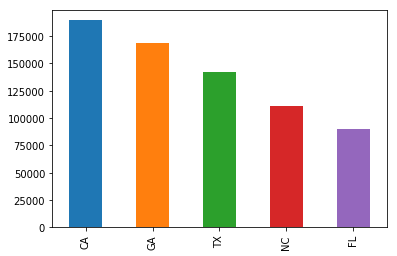

In [50]:
#Top 5 states
finaldf['STATE'].value_counts().head().plot(kind='bar')

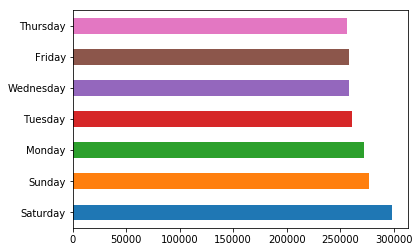

In [83]:
#More fires on weekend
finaldf['DISC_DAY_OF_WEEK'].value_counts().plot(kind='barh')
plt.show()

In [237]:
#baseline model will not contain features with nulls
baseline = df.drop(['CONTDATE','duration','CONT_MONTH','CONT_DAY_OF_WEEK','DATE'], axis=1)

In [241]:
baseline = pd.get_dummies(baseline.drop(['STAT_CAUSE_DESCR'], axis=1))

In [512]:
baseline.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,DISC_MONTH,STATE_AK,STATE_AL,STATE_AR,STATE_AZ,...,SOURCE_SYSTEM_TYPE_FED,SOURCE_SYSTEM_TYPE_INTERAGCY,SOURCE_SYSTEM_TYPE_NONFED,DISC_DAY_OF_WEEK_Friday,DISC_DAY_OF_WEEK_Monday,DISC_DAY_OF_WEEK_Saturday,DISC_DAY_OF_WEEK_Sunday,DISC_DAY_OF_WEEK_Thursday,DISC_DAY_OF_WEEK_Tuesday,DISC_DAY_OF_WEEK_Wednesday
0,2005,40.036944,-121.005833,0.10,5.0,2,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2004,38.933056,-120.404444,0.25,5.0,5,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,2004,38.984167,-120.735556,0.10,13.0,5,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,2004,38.559167,-119.913333,0.10,5.0,6,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,2004,38.559167,-119.933056,0.10,5.0,6,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


## Testing models

In [258]:
X = baseline.values
y = df['STAT_CAUSE_DESCR']

In [464]:
X_sub,X_out,y_sub,y_out = train_test_split(X,y,test_size=0.9,random_state = 0, stratify = y)

In [480]:
#scale for logistic model
std = StandardScaler()
std.fit(X_train_sub)
X_scale = std.transform(X_sub)
X_scale = pd.DataFrame(X_scale)

In [482]:
logacc = []
logprec = []
logrec = []
logf1 = []
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_scale,y_sub):
    X_train_sub, X_val_sub = X_scale.iloc[train_index], X_scale.iloc[test_index]
    y_train_sub, y_val_sub = y_sub.iloc[train_index], y_sub.iloc[test_index]
    

    
    # Logistic Regression
    logr = LogisticRegression()
    logr.fit(X_train_sub, y_train_sub)
    logr_pred = logr.predict(X_val_sub)
    print('Unweighted Accuracy: ',accuracy_score(y_val_sub,logr_pred))
    print('Unweighted Precision: ',precision_score(y_val_sub,logr_pred,average='macro'))
    print('Unweighted Recall: ',recall_score(y_val_sub,logr_pred,average='macro'))
    print('Unweighted f1: ',f1_score(y_val_sub,logr_pred,average='macro'))
    logacc.append(accuracy_score(y_val_sub,logr_pred))
    logprec.append(precision_score(y_val_sub,logr_pred,average='macro'))
    logrec.append(recall_score(y_val_sub,logr_pred,average='macro'))
    logf1.append(f1_score(y_val_sub,logr_pred,average='macro'))
    
    
    

Unweighted Accuracy:  0.436524605854


/Users/djurk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Unweighted Precision:  0.251382325618
Unweighted Recall:  0.231647037551


/Users/djurk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Unweighted f1:  0.2127915404
Unweighted Accuracy:  0.435685419547
Unweighted Precision:  0.20492949467
Unweighted Recall:  0.213255299974
Unweighted f1:  0.19481127694
Unweighted Accuracy:  0.441395447777
Unweighted Precision:  0.235625448815
Unweighted Recall:  0.239496665154
Unweighted f1:  0.220023339032
Unweighted Accuracy:  0.43515834818
Unweighted Precision:  0.237525923599
Unweighted Recall:  0.229548495619
Unweighted f1:  0.214775769036
Unweighted Accuracy:  0.43373397862
Unweighted Precision:  0.234804824591
Unweighted Recall:  0.229714411716
Unweighted f1:  0.213319561798


In [489]:
%%time

log_weight_acc = []
log_weight_prec = []
log_weight_rec = []
log_weight_f1 = []
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_scale,y_sub):
    X_train_sub, X_val_sub = X_scale.iloc[train_index], X_scale.iloc[test_index]
    y_train_sub, y_val_sub = y_sub.iloc[train_index], y_sub.iloc[test_index]
    
    #Weighted Regression with regularization
    lr_weight = LogisticRegression(class_weight={'Debris Burning' : 0.5, 'Miscellaneous' : 0.6, 'Arson':0.6,'Lightning':0.6
                                            ,'Missing/Undefined':0.9,'Equipment Use':1.1,'Campfire':1.8, 'Children':2.5
                                            ,'Smoking':3,'Railroad':4,'Powerline':10,'Fireworks':13,'Structure':40},C=1)
    lr_weight.fit(X_train_sub,y_train_sub)
    logr_weight_pred = lr_weight.predict(X_val_sub)

    print('Weighted Low C Accuracy: ',accuracy_score(y_val_sub,logr_weight_pred))
    print('Weighted Low C Precision: ',precision_score(y_val_sub,logr_weight_pred,average='macro'))
    print('Weighted Low C Recall: ',recall_score(y_val_sub,logr_weight_pred,average='macro'))
    print('Weighted Low C f1: ',f1_score(y_val_sub,logr_weight_pred,average='macro'))
    log_weight_acc.append(accuracy_score(y_val_sub,logr_weight_pred))
    log_weight_prec.append(precision_score(y_val_sub,logr_weight_pred,average='macro'))
    log_weight_rec.append(recall_score(y_val_sub,logr_weight_pred,average='macro'))
    log_weight_f1.append(f1_score(y_val_sub,logr_weight_pred,average='macro'))

Weighted Low C Accuracy:  0.379948422088
Weighted Low C Precision:  0.254945076764
Weighted Low C Recall:  0.316146806278
Weighted Low C f1:  0.246451819232
Weighted Low C Accuracy:  0.376635116452
Weighted Low C Precision:  0.254494941458
Weighted Low C Recall:  0.321430473964
Weighted Low C f1:  0.246301314206
Weighted Low C Accuracy:  0.380105296745
Weighted Low C Precision:  0.257421671848
Weighted Low C Recall:  0.31540332872
Weighted Low C f1:  0.245203084921
Weighted Low C Accuracy:  0.364745924961
Weighted Low C Precision:  0.255449382115
Weighted Low C Recall:  0.322005712073
Weighted Low C f1:  0.245138285456
Weighted Low C Accuracy:  0.378530021805
Weighted Low C Precision:  0.260483302042
Weighted Low C Recall:  0.322771167758
Weighted Low C f1:  0.249831270677
CPU times: user 20min 33s, sys: 2.5 s, total: 20min 35s
Wall time: 20min 38s


In [496]:
rfcacc = []
rfcprec = []
rfcrec = []
rfcf1 = []
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_scale,y_sub):
    X_train_sub, X_val_sub = X_scale.iloc[train_index], X_scale.iloc[test_index]
    y_train_sub, y_val_sub = y_sub.iloc[train_index], y_sub.iloc[test_index]

    rfc = RandomForestClassifier(n_estimators=1000, n_jobs=2,  class_weight={'Debris Burning' : 0.5, 'Miscellaneous' : 0.6, 'Arson':0.6,'Lightning':0.6
                                            ,'Missing/Undefined':0.9,'Equipment Use':1.1,'Campfire':1.8, 'Children':2.5
                                            ,'Smoking':3,'Railroad':4,'Powerline':10,'Fireworks':13,'Structure':40})
    rfc.fit(X_train_sub,y_train_sub)
    rfc_pred = rfc.predict(X_val_sub)
    
    print('Weighted RFC Accuracy: ',accuracy_score(y_val_sub,rfc_pred))
    print('Weighted RFC Precision: ',precision_score(y_val_sub,rfc_pred,average='macro'))
    print('Weighted RFC Recall: ',recall_score(y_val_sub,rfc_pred,average='macro'))
    print('Weighted RFC f1: ',f1_score(y_val_sub,rfc_pred,average='macro'))
    rfcacc.append(accuracy_score(y_val_sub,rfc_pred))
    rfcprec.append(precision_score(y_val_sub,rfc_pred,average='macro'))
    rfcrec.append(recall_score(y_val_sub,rfc_pred,average='macro'))
    rfcf1.append(f1_score(y_val_sub,rfc_pred,average='macro'))

Weighted Low C Accuracy:  0.536330524021
Weighted Low C Precision:  0.407662111179
Weighted Low C Recall:  0.34517458311
Weighted Low C f1:  0.357826881842
Weighted Low C Accuracy:  0.535653514836
Weighted Low C Precision:  0.399690275658
Weighted Low C Recall:  0.344207174095
Weighted Low C f1:  0.355873584256
Weighted Low C Accuracy:  0.541081684748
Weighted Low C Precision:  0.416394921977
Weighted Low C Recall:  0.350514437346
Weighted Low C f1:  0.362834647557
Weighted Low C Accuracy:  0.540112213152
Weighted Low C Precision:  0.416106769851
Weighted Low C Recall:  0.351718553045
Weighted Low C f1:  0.364558009106
Weighted Low C Accuracy:  0.539195872999
Weighted Low C Precision:  0.409908010112
Weighted Low C Recall:  0.347482554646
Weighted Low C f1:  0.360082838878


In [514]:
print('Unweighted LogR CV Accuracy score:',np.mean(logacc))
print('Unweighted LogR CV Precision score:',np.mean(logprec))
print('Unweighted LogR CV Recall score:',np.mean(logrec))
print('Unweighted LogR CV F1 score:',np.mean(logf1), '\n')

print('Weighted LogR CV Accuracy score:',np.mean(log_weight_acc))
print('Weighted LogR CV Precision score:',np.mean(log_weight_prec))
print('Weighted LogR CV Recall score:',np.mean(log_weight_rec))
print('Weighted LogR CV F1 score:',np.mean(log_weight_f1), '\n')

print('Weighted RFC CV Accuracy score:',np.mean(rfcacc))
print('Weighted RFC CV Precision score:',np.mean(rfcprec))
print('Weighted RFC CV Recall score:',np.mean(rfcrec))
print('Weighted RFC CV F1 score:',np.mean(rfcf1))


Unweighted LogR CV Accuracy score: 0.436499559996
Unweighted LogR CV Precision score: 0.232853603459
Unweighted LogR CV Recall score: 0.228732382003
Unweighted LogR CV F1 score: 0.211144297441 

Weighted LogR CV Accuracy score: 0.37599295641
Weighted LogR CV Precision score: 0.256558874845
Weighted LogR CV Recall score: 0.319551497759
Weighted LogR CV F1 score: 0.246585154898 

Weighted RFC CV Accuracy score: 0.538474761951
Weighted RFC CV Precision score: 0.409952417755
Weighted RFC CV Recall score: 0.347819460448
Weighted RFC CV F1 score: 0.360235192328


In [473]:
df['STAT_CAUSE_DESCR'].value_counts()

Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: STAT_CAUSE_DESCR, dtype: int64

In [521]:
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_CODE,SOURCE_SYSTEM_TYPE,DATE,CONTDATE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,CONT_MONTH,CONT_DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,0.10,A,5.0,FED,2005-02-02,2005-02-02,0.187500,2,Wednesday,2.0,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,0.25,A,5.0,FED,2004-05-12,2004-05-12,0.281250,5,Wednesday,5.0,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,0.10,A,13.0,FED,2004-05-31,2004-05-31,0.043750,5,Monday,5.0,Monday
3,2004,Lightning,38.559167,-119.913333,CA,0.10,A,5.0,FED,2004-06-28,2004-07-03,4.916667,6,Monday,7.0,Saturday
4,2004,Lightning,38.559167,-119.933056,CA,0.10,A,5.0,FED,2004-06-28,2004-07-03,4.833333,6,Monday,7.0,Saturday


## Adding in features with nulls

In [3]:
dfload = pd.read_csv('fire_data.csv')

/Users/djurk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dfload.head()

,Unnamed: 0,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_CODE,SOURCE_SYSTEM_TYPE,DATE,CONTDATE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,CONT_MONTH,CONT_DAY_OF_WEEK
0,0,2005,Miscellaneous,40.036944,-121.005833,CA,0.10,A,5.0,FED,2005-02-02,2005-02-02,0.187500,2,Wednesday,2.0,Wednesday
1,1,2004,Lightning,38.933056,-120.404444,CA,0.25,A,5.0,FED,2004-05-12,2004-05-12,0.281250,5,Wednesday,5.0,Wednesday
2,2,2004,Debris Burning,38.984167,-120.735556,CA,0.10,A,13.0,FED,2004-05-31,2004-05-31,0.043750,5,Monday,5.0,Monday
3,3,2004,Lightning,38.559167,-119.913333,CA,0.10,A,5.0,FED,2004-06-28,2004-07-03,4.916667,6,Monday,7.0,Saturday
4,4,2004,Lightning,38.559167,-119.933056,CA,0.10,A,5.0,FED,2004-06-28,2004-07-03,4.833333,6,Monday,7.0,Saturday


In [4]:
finaldf = dfload.drop(['Unnamed: 0', 'CONTDATE','CONT_DAY_OF_WEEK','DATE','FIRE_SIZE_CLASS','STAT_CAUSE_DESCR', 'CONT_MONTH', 'SOURCE_SYSTEM_TYPE'], axis=1)

In [5]:
finaldf.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK
0,2005,40.036944,-121.005833,CA,0.10,5.0,0.187500,2,Wednesday
1,2004,38.933056,-120.404444,CA,0.25,5.0,0.281250,5,Wednesday
2,2004,38.984167,-120.735556,CA,0.10,13.0,0.043750,5,Monday
3,2004,38.559167,-119.913333,CA,0.10,5.0,4.916667,6,Monday
4,2004,38.559167,-119.933056,CA,0.10,5.0,4.833333,6,Monday


In [6]:
finaldfdummy = pd.get_dummies(finaldf, columns = ['STATE','OWNER_CODE','DISC_MONTH','DISC_DAY_OF_WEEK','FIRE_YEAR'])

In [7]:
finaldfdummy.head()

,LATITUDE,LONGITUDE,FIRE_SIZE,duration,STATE_AK,STATE_AL,STATE_AR,STATE_AZ,STATE_CA,STATE_CO,...,FIRE_YEAR_2006,FIRE_YEAR_2007,FIRE_YEAR_2008,FIRE_YEAR_2009,FIRE_YEAR_2010,FIRE_YEAR_2011,FIRE_YEAR_2012,FIRE_YEAR_2013,FIRE_YEAR_2014,FIRE_YEAR_2015
0,40.036944,-121.005833,0.10,0.187500,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38.933056,-120.404444,0.25,0.281250,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,38.984167,-120.735556,0.10,0.043750,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,38.559167,-119.913333,0.10,4.916667,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,38.559167,-119.933056,0.10,4.833333,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
finaldfdummy = finaldfdummy.fillna(-100)

In [10]:
X = pd.DataFrame(finaldfdummy.values)
y = dfload['STAT_CAUSE_DESCR']

In [11]:
X_sub,X_out,y_sub,y_out = train_test_split(X,y,test_size=0.8,random_state = 0, stratify = y)

In [15]:
rfc_acc = []
rfc_prec = []
rfc_rec = []
rfc_f1 = []
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_sub,y_sub):
    X_train_sub, X_val_sub = X_sub.iloc[train_index], X_sub.iloc[test_index]
    y_train_sub, y_val_sub = y_sub.iloc[train_index], y_sub.iloc[test_index]

    rfc = RandomForestClassifier(n_estimators=1000, verbose=1, n_jobs=2,  class_weight={'Debris Burning' : 0.5, 'Miscellaneous' : 0.6, 'Arson':0.6,'Lightning':0.6
                                            ,'Missing/Undefined':0.9,'Equipment Use':1.1,'Campfire':1.8, 'Children':2.5
                                            ,'Smoking':3,'Railroad':4,'Powerline':10,'Fireworks':13,'Structure':40})
    rfc.fit(X_train_sub,y_train_sub)
    rfc_pred = rfc.predict(X_val_sub)
    

    rfc_acc.append(accuracy_score(y_val_sub,rfc_pred))
    rfc_prec.append(precision_score(y_val_sub,rfc_pred,average='macro'))
    rfc_rec.append(recall_score(y_val_sub,rfc_pred,average='macro'))
    rfc_f1.append(f1_score(y_val_sub,rfc_pred,average='macro'))

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   21.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:  8.3min finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   41.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  6.5min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:  8.2min finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:

## SCORES

In [19]:
print(np.mean(rfc_acc))
print(np.mean(rfc_prec))
print(np.mean(rfc_rec))
print(np.mean(rfc_f1))


0.557287664621
0.440697979542
0.376188149789
0.389220217121


In [31]:
X_train,X_test,y_train,y_test = train_test_split(X_sub,y_sub,test_size = 0.7, random_state = 0, stratify = y_sub)

In [34]:
boost = xgb.XGBClassifier(learning_rate=0.05,max_depth=3,subsample=0.75,n_estimators=500, class_weight={'Debris Burning' : 0.5, 'Miscellaneous' : 0.6, 'Arson':0.6,'Lightning':0.6
                                            ,'Missing/Undefined':0.9,'Equipment Use':1.1,'Campfire':1.8, 'Children':2.5
                                            ,'Smoking':3,'Railroad':4,'Powerline':10,'Fireworks':13,'Structure':40})

boost.fit(X_train,y_train)
boost_pred = boost.predict(X_test)
print(accuracy_score(y_test,boost_pred))
print(precision_score(y_test,boost_pred,average='macro'))
print(recall_score(y_test,boost_pred,average='macro'))
print(f1_score(y_test,boost_pred,average='macro'))

0.517571581594
0.408998678054
0.333464992858
0.337923493431
